In [1]:
# librerias
 
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 
pd.set_option('display.max_columns', 500)  # Ver más columnas de los dataframes

# Ver gráficos de matplotlib en jupyter notebook/lab
%matplotlib inline

In [2]:
from lectura import lectura
df2 = pd.DataFrame()
df2 = lectura()

In [3]:
df2.shape

(4803, 23)

Limpiamos los datos

In [4]:
import preprocesamiento as pr

In [5]:
pr.filtro_nulos(df2)

In [6]:
X = df2[['vote_average','vote_count']].values
y = df2['popularity']

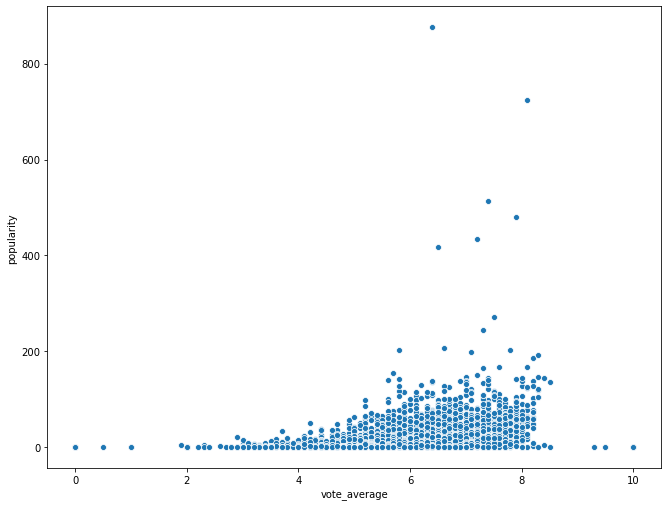

In [7]:
import graficos as gr

#Realizamos un grafico de promedio de votos vs popularidad
gr.grafico_vote_average(df2)

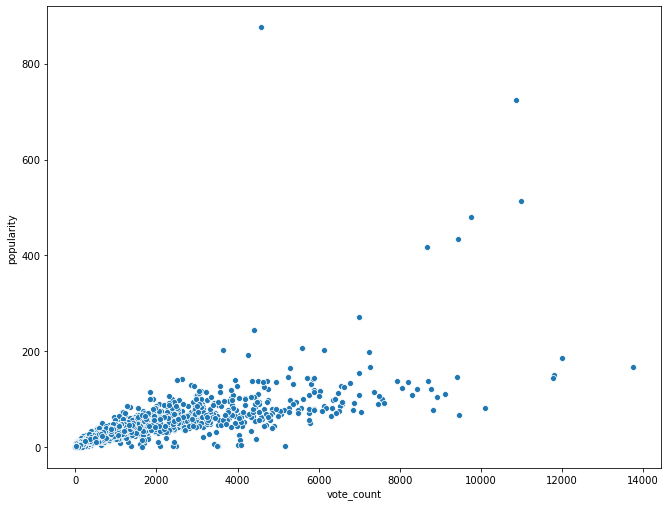

In [8]:
#Realizamos un grafico del numero de votos vs popularidad
gr.grafico_vote_count(df2)

In [9]:
C,m = pr.obtener_valores(df2)

In [10]:
q_movies = pr.filtro_votos(df2,m)

In [11]:
# Metrica para determinar que pelicula es mejor que otra
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [12]:
# Definimos esta nueva metrica y calculamos su valor
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

In [13]:
#Ordenamos las peliculas segun la metrica definida arriba
q_movies = q_movies.sort_values('score', ascending=False)

#Imprimimos las primeras 10 peliculas
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


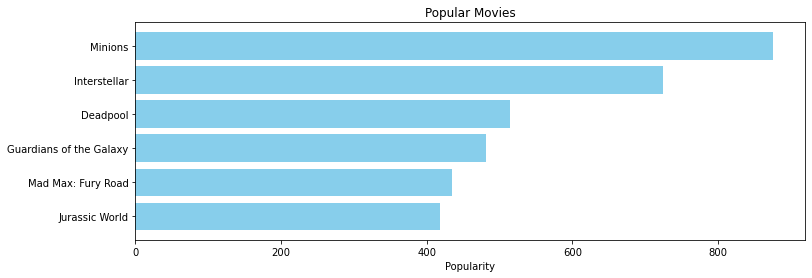

In [14]:
#Graficamos las peliculas mas populares
gr.peliculas_populares(df2)

In [15]:
df2['overview'].head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

In [16]:
import modelos as md

In [17]:
tfidf_matrix = md.vectorizacion(df2)

#Forma de la matriz
tfidf_matrix.shape

(4803, 20978)

In [18]:
# Importamos linear kernel
from sklearn.metrics.pairwise import linear_kernel

# Computamos la similaridad del coseno de nuestra matriz
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [19]:
#Construimos un mapeo de los inidices y los nombres de las peliculas
indices = pd.Series(df2.index, index=df2['title']).drop_duplicates()

In [20]:
index = md.get_recommendations('The Dark Knight Rises',cosine_sim,indices)

In [21]:
df2['title'].iloc[index]

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: title, dtype: object

In [22]:
index = md.get_recommendations('The Avengers',cosine_sim,indices)

In [23]:
df2['title'].iloc[index]

7               Avengers: Age of Ultron
3144                            Plastic
1715                            Timecop
4124                 This Thing of Ours
3311              Thank You for Smoking
3033                      The Corruptor
588     Wall Street: Money Never Sleeps
2136         Team America: World Police
1468                       The Fountain
1286                        Snowpiercer
Name: title, dtype: object

In [24]:
# Analizamos sus distintas caracteristicas como el elenco, genero, etc.
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(literal_eval)

In [25]:
# Funcion que retorna el nombre del director, si es nulo retorna NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [26]:
# Funcion que retorna los 3 elementos principales de la pelicula.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Si existen mas de tres solo retornar los tres primeros, en otro caso retornar la lista entera.
        if len(names) > 3:
            names = names[:3]
        return names

    #En caso de no tener datos, retorna una lista vacia
    return []

In [27]:
# Realizamos el cambio para los principales 3 componentes que encontramos anteriormente.
df2['director'] = df2['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(get_list)

In [28]:
# Vemos los principales componentes de las primeras peliculas
df2[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


In [29]:
# Filtramos los datos de nuestro dataframe.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    df2[feature] = df2[feature].apply(pr.clean_data)

In [30]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
df2['soup'] = df2.apply(create_soup, axis=1)

In [31]:
# Importamos CountVectorizer y creamos una matriz de recuento
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df2['soup'])

In [32]:
# Computamos la matriz de coseno similitud a partir de la matriz de recuento
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [33]:
# Reseteamos los indices y creamos un mapeo por nombre de pelicula
df2 = df2.reset_index()
indices = pd.Series(df2.index, index=df2['title'])

In [34]:
index = md.get_recommendations('The Dark Knight Rises', cosine_sim2, indices)

In [35]:
df2['title'].iloc[index]

65               The Dark Knight
119                Batman Begins
4638    Amidst the Devil's Wings
1196                The Prestige
3073           Romeo Is Bleeding
3326              Black November
1503                      Takers
1986                      Faster
303                     Catwoman
747               Gangster Squad
Name: title, dtype: object

In [36]:
index = md.get_recommendations('The Godfather', cosine_sim2,indices)

In [37]:
df2['title'].iloc[index]

867      The Godfather: Part III
2731      The Godfather: Part II
4638    Amidst the Devil's Wings
2649           The Son of No One
1525              Apocalypse Now
1018             The Cotton Club
1170     The Talented Mr. Ripley
1209               The Rainmaker
1394               Donnie Brasco
1850                    Scarface
Name: title, dtype: object